In [1]:
import warnings
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import gc
from sklearn.metrics import auc, roc_curve
from sklearn.preprocessing import LabelEncoder

import h2o
from h2o.frame import H2OFrame
from h2o.estimators.glm import H2OGeneralizedLinearEstimator
from h2o.grid.grid_search import H2OGridSearch

import lightgbm as lgb

%matplotlib inline

# Load Data

In [2]:
train = pd.read_csv('./data/train_clean.csv')
test = pd.read_csv('./data/test_clean.csv')
print('Train:\t', train.shape)
print('Test: \t', test.shape)

Train:	 (307506, 172)
Test: 	 (48744, 171)


In [3]:
# define categorical features
cat_feature = ['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 
               'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 
               'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE', 
               'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE', 'FONDKAPREMONT_MODE', 
               'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE', 
               'Binary_CREDIT_DAY_OVERDUE', 'FLAG_MOBIL', 'FLAG_EMP_PHONE', 
               'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 
               'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION',  
               'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 
               'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'FLAG_DOCUMENT_2', 
               'FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5', 
               'FLAG_DOCUMENT_6', 'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_8', 
               'FLAG_DOCUMENT_9', 'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11', 
               'FLAG_DOCUMENT_12', 'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14', 
               'FLAG_DOCUMENT_15', 'FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_17', 
               'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19',  'FLAG_DOCUMENT_20', 
               'FLAG_DOCUMENT_21', ]

dis_feature = ['CNT_CHILDREN', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT', 
               'REGION_RATING_CLIENT_W_CITY', 'HOUR_APPR_PROCESS_START', 
               'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE', 
               'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE', 
               'Total_BUREAU', 'Closed_BUREAU', 'Active_BUREAU', 'Sold_BUREAU', 
               'Bad_BUREAU', 'Count_AMT_CREDIT_MAX_OVERDUE', 'Credit_CREDIT_TYPE', 
               'Loan_CREDIT_TYPE', 'Count_POS_CASH', 'Completed_CASH_CONTRACT', 
               'Other_CASH_CONTRACT', 'Count_Credit_Card', 'Active_Credit_CONTRACT', 
               'Completed_Credit_CONTRACT', 'Other_Credit_CONTRACT', 'Count_installment', 
               'Count_prev', 'Count_prev_Cash_loan', 'Count_prev_Consumer_loan', 
               'Count_prev_Revolving_loan', 'Count_Y_prev_FLAG_LAST_APPL_PER_CONTRACT', 
               'Count_N_prev_FLAG_LAST_APPL_PER_CONTRACT', 'Count_1_prev_NFLAG_LAST_APPL_IN_DAY', 
               'Count_0_prev_NFLAG_LAST_APPL_IN_DAY', 'Count_Approved_prev_NAME_CONTRACT_STATUS', 
               'Count_Canceled_prev_NAME_CONTRACT_STATUS', 'Count_Refused_prev_NAME_CONTRACT_STATUS', 
               'Count_Unused_prev_NAME_CONTRACT_STATUS',  'Count_Cash_prev_NAME_PAYMENT_TYPE',
               'Count_XNA_prev_NAME_PAYMENT_TYPE', 'Count_Noncash_prev_NAME_PAYMENT_TYPE', 
               'Count_Unaccompanied_prev_NAME_TYPE_SUITE', 'Count_Accompanied_prev_NAME_TYPE_SUITE', 
               'Count_Other_NAME_TYPE_SUITE', 'Count_Repeater_prev_NAME_CLIENT_TYPE', 
               'Count_New_prev_NAME_CLIENT_TYPE', 'Count_Refreshed_prev_NAME_CLIENT_TYPE', 
               'Count_POS_prev_NAME_PORTFOLIO', 'Count_Cash_prev_NAME_PORTFOLIO', 
               'Count_Cards_prev_NAME_PORTFOLIO', 'Count_Other_prev_NAME_PORTFOLIO', 
               'Count_XNA_prev_NAME_PRODUCT_TYPE', 'Count_xsell_prev_NAME_PRODUCT_TYPE', 
               'Count_walkin_prev_NAME_PRODUCT_TYPE', 'Count_0_prev_NFLAG_INSURED_ON_APPROVAL', 
               'Count_1_prev_NFLAG_INSURED_ON_APPROVAL']

con_feature = ['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 
               'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 
               'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'EXT_SOURCE_2', 
               'EXT_SOURCE_3', 'DAYS_LAST_PHONE_CHANGE', 'Sum_CASH_MONTH_BALANCE', 
               'Mean_CASH_MONTH_BALANCE', 'Median_CASH_MONTH_BALANCE', 'Sum_CASH_CNT_INSTALMENT', 
               'Mean_CASH_CNT_INSTALMENT', 'Median_CASH_CNT_INSTALMENT', 
               'Sum_CASH_CNT_INSTALMENT_FUTURE', 'Mean_CASH_CNT_INSTALMENT_FUTURE', 
               'Median_CASH_CNT_INSTALMENT_FUTURE', 'Active_CASH_CONTRACT', 
               'Sum_CASH_SK_DPD', 'Mean_CASH_SK_DPD', 'Median_CASH_SK_DPD', 'Sum_CASH_SK_DPD_DEF', 
               'Mean_CASH_SK_DPD_DEF', 'Median_CASH_SK_DPD_DEF', 'Sum_NUM_INSTALMENT_VERSION', 
               'Mean_NUM_INSTALMENT_VERSION', 'Median_NUM_INSTALMENT_VERSION', 
               'Sum_NUM_INSTALMENT_NUMBER', 'Mean_NUM_INSTALMENT_NUMBER', 
               'Median_NUM_INSTALMENT_NUMBER', 'Sum_DAYS_INSTALMENT', 'Mean_DAYS_INSTALMENT',
               'Median_DAYS_INSTALMENT', 'Sum_DAYS_ENTRY_PAYMENT', 'Mean_DAYS_ENTRY_PAYMENT', 
               'Median_DAYS_ENTRY_PAYMENT', 'Sum_AMT_INSTALMENT', 'Mean_AMT_INSTALMENT', 
               'Median_AMT_INSTALMENT', 'Sum_AMT_PAYMENT', 'Mean_AMT_PAYMENT', 'Median_AMT_PAYMENT',
               'Sum_prev_AMT_ANNUITY', 'Mean_prev_AMT_ANNUITY', 'Median_prev_AMT_ANNUITY', 
               'Sum_prev_AMT_APPLICATION', 'Mean_prev_AMT_APPLICATION', 'Median_prev_AMT_APPLICATION', 
               'Sum_prev_AMT_CREDIT', 'Mean_prev_AMT_CREDIT', 'Median_prev_AMT_CREDIT', 
               'Sum_prev_AMT_DOWN_PAYMENT', 'Sum_prev_AMT_GOODS_PRICE',  'Mean_prev_AMT_GOODS_PRICE', 
               'Median_prev_AMT_GOODS_PRICE', 'Sum_prev_RATE_DOWN_PAYMENT', 'Sum_prev_DAYS_DECISION', 
               'Mean_prev_DAYS_DECISION', 'Median_prev_DAYS_DECISION','Sum_prev_CNT_PAYMENT', 
               'Mean_prev_CNT_PAYMENT', 'Median_prev_CNT_PAYMENT']

features = cat_feature + dis_feature + con_feature

# define numerical and categorical features
print('Categorical:\t', len(cat_feature))
print('Discrete:\t', len(dis_feature))
print('Continuous:\t', len(con_feature))
print('Total:\t\t', len(features))

Categorical:	 49
Discrete:	 55
Continuous:	 66
Total:		 170


# H2O Logistic Regression

In [4]:
# # Initialize H2O cluster
# h2o.init(nthreads=-1, max_mem_size='45G')
# h2o.remove_all()

# # Transform to H2O Frame, and make sure the target variable is categorical
# h2o_train = H2OFrame(train[features + ['TARGET']])
# h2o_test = H2OFrame(test[features])

# # transform into categorical
# h2o_train['TARGET'] = h2o_train['TARGET'].asfactor()

# for name in cat_feature:
#     h2o_train[name] = h2o_train[name].asfactor()
#     h2o_test[name] = h2o_test[name].asfactor()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "1.8.0_121"; OpenJDK Runtime Environment (Zulu 8.20.0.5-linux64) (build 1.8.0_121-b15); OpenJDK 64-Bit Server VM (Zulu 8.20.0.5-linux64) (build 25.121-b15, mixed mode)
  Starting server from /home/ubuntu/anaconda3/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmphe8082_2
  JVM stdout: /tmp/tmphe8082_2/h2o_ubuntu_started_from_python.out
  JVM stderr: /tmp/tmphe8082_2/h2o_ubuntu_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321... successful.


H2O cluster uptime:,02 secs
H2O cluster timezone:,Etc/UTC
H2O data parsing timezone:,UTC
H2O cluster version:,3.18.0.11
H2O cluster version age:,1 month and 26 days
H2O cluster name:,H2O_from_python_ubuntu_a63uu4
H2O cluster total nodes:,1
H2O cluster free memory:,40 Gb
H2O cluster total cores:,4
H2O cluster allowed cores:,4
H2O cluster status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [5]:
# # Train logistic regression model with Lasso using grid search
# hyper_parameters = {'alpha': [0, 0.2, 0.4, 0.6, 0.8, 1.0], 
#                     'lambda': [0, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1]}

# # Create GLM model
# glm = H2OGeneralizedLinearEstimator(family='binomial', balance_classes=False, 
#                                     early_stopping=True, custom_metric_func='auc',
#                                     keep_cross_validation_predictions=True, nfolds=5)

# # Grid search
# glm_grid = H2OGridSearch(glm, hyper_parameters, grid_id='GLM')
# glm_grid.train(x=features, y='TARGET', training_frame=h2o_train)

glm Grid Build progress: |████████████████████████████████████████████████| 100%


In [6]:
# # Get the grid search result, sorted by AUC
# glm_models = glm_grid.get_grid(sort_by='auc', decreasing=True)

# # Choose the best model
# best_glm = glm_grid.models[0]

# glm_models

      alpha    lambda     model_ids                  auc
0     [0.6]     [0.0]   GLM_model_3   0.7625809382617911
1     [0.2]  [1.0E-6]   GLM_model_7    0.762359770013403
2     [1.0]     [0.0]   GLM_model_5    0.762315330900026
3     [0.8]     [0.0]   GLM_model_4   0.7622445826572887
4     [0.0]  [1.0E-5]  GLM_model_12   0.7622422076690701
5     [1.0]  [1.0E-6]  GLM_model_11   0.7622236662018853
6     [0.4]  [1.0E-5]  GLM_model_14   0.7622003362106626
7     [0.2]     [0.0]   GLM_model_1   0.7621587422094772
8     [1.0]  [1.0E-5]  GLM_model_17   0.7621483032912021
9     [0.0]     [0.0]   GLM_model_0   0.7620923202045793
10    [0.0]  [1.0E-6]   GLM_model_6   0.7620759740980689
11    [0.8]  [1.0E-5]  GLM_model_16   0.7620694935409931
12    [0.8]  [1.0E-6]  GLM_model_10   0.7620598417490485
13    [0.6]  [1.0E-6]   GLM_model_9   0.7620425955810004
14    [0.6]  [1.0E-5]  GLM_model_15   0.7620174882675012
15    [0.0]  [1.0E-4]  GLM_model_18   0.7619917815780001
16    [0.4]     [0.0]   GLM_mod

glm prediction progress: |████████████████████████████████████████████████| 100%
glm prediction progress: |████████████████████████████████████████████████| 100%


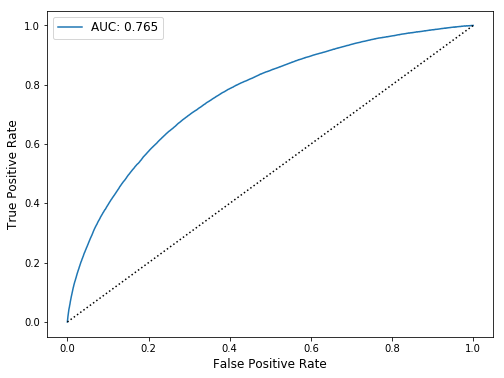

In [7]:
# # Make predictions
# glm_train_pred = best_glm.predict(h2o_train).as_data_frame()['p1'].values
# glm_test_pred = best_glm.predict(h2o_test).as_data_frame()['p1'].values

# # Build the ROC curve
# glm_fpr, glm_tpr, _ = roc_curve(train['TARGET'].values, glm_train_pred)
# glm_auc = np.round(auc(glm_fpr, glm_tpr), 3)

# fig, ax = plt.subplots(figsize=(8, 6))
# ax.plot(glm_fpr, glm_tpr, label='AUC: ' + str(glm_auc))
# ax.plot(glm_fpr, glm_fpr, 'k:')
# ax.set_xlabel('False Positive Rate', fontsize=12)
# ax.set_ylabel('True Positive Rate', fontsize=12)
# ax.legend(fontsize=12)
# plt.show()

In [9]:
# # make prediction file
# test_id = test['SK_ID_CURR'].values
# test_pred = glm_test_pred

# glm_csv = pd.DataFrame({'SK_ID_CURR': test_id, 'TARGET': test_pred}, 
#                        columns=['SK_ID_CURR', 'TARGET'])
# glm_csv.to_csv('./result/all_feature_h2o_logistic_regression_naive.csv', index=False)

# # Shutdown h2o instance
# h2o.cluster().shutdown()

H2O session _sid_a3c3 closed.


# LightGBM Random Forest

# LightGBM Boosting